# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.
import pandas as pd

In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [3]:
# identify feature and target column names
target_col = ['area']
feat_cols = fires_dt.columns.difference(target_col)
target_col, feat_cols

(['area'],
 Index(['coord_x', 'coord_y', 'day', 'dc', 'dmc', 'ffmc', 'isi', 'month',
        'rain', 'rh', 'temp', 'wind'],
       dtype='object'))

In [4]:
# wire columns names into fires_dt data frame
X = fires_dt[feat_cols]
# convert y to 1d array/series
y = fires_dt[target_col].values.ravel()

X.shape, y.shape

((517, 12), (517,))

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer


# identify feature columns by its data type
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# num pipe, imput with median then standardize the values
num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

# cat pipe, imput with mode then onehot encoding
cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# preproc to wire the pipe to actual columns
preproc1 = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols),
])

preproc1.get_params

<bound method ColumnTransformer.get_params of ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['coord_x', 'coord_y', 'dc', 'dmc', 'ffmc', 'isi', 'rain', 'rh', 'temp',
       'wind'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['day', 'month'], dtype='object'))])>

### Preproc 2

Create preproc2 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [6]:
# identify features with skewed distribution
num_skew_cols = ['dc', 'ffmc', 'isi', 'rain']

# # identify feature columns by its data type
num_nor_cols = X.select_dtypes(include=['float64', 'int64']).columns.difference(num_skew_cols)
cat_cols = X.select_dtypes(include=['object']).columns


# num pipe for no skew
num_nor_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# num pipe for skewed features:
num_skew_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('transform', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler())
])

# cat pipe
cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# preproc to wire the pipe to actual columns
preproc2 = ColumnTransformer([
    ('num_skew', num_skew_pipe, num_skew_cols),
    ('num_nor', num_nor_pipe, num_nor_cols),
    ('cat', cat_pipe, cat_cols)
])

preproc2.get_params

<bound method ColumnTransformer.get_params of ColumnTransformer(transformers=[('num_skew',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('transform',
                                                  PowerTransformer(standardize=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['dc', 'ffmc', 'isi', 'rain']),
                                ('num_nor',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['coord_x', 'coord_y', 'dmc', 'rh', 'temp', 'wind'], dtype='object')),
                                ('cat',
                                 Pipeline(ste

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [7]:
# Pipeline A = preproc1 + baseline
from sklearn.linear_model import Ridge

pipe_a = Pipeline(
    steps=[
        ('preprocessing', preproc1),
        ('regressor', Ridge())
    ]
)

In [8]:
# Pipeline B = preproc2 + baseline
pipe_b = Pipeline(
    steps=[
        ('preprocessing', preproc2),
        ('regressor', Ridge())
    ]
)

In [9]:
# Pipeline C = preproc1 + advanced model
from sklearn.ensemble import RandomForestRegressor

pipe_c = Pipeline(
    steps=[
        ('preprocessing', preproc1),
        ('regressor', RandomForestRegressor(random_state=42))
    ]
)

In [10]:
# Pipeline D = preproc2 + advanced model
pipe_d = Pipeline(
    steps=[
        ('preprocessing', preproc2),
        ('regressor', RandomForestRegressor(random_state=42))
    ]
)   

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [11]:
# tuning for alpha with Ridge as baseline models for both preproc1 and preproc2
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=42
)

# baseline regression ridge parameter
ridge_param_grid = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0]
}
# scoring metrics
scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error']

grid_a = GridSearchCV(
    estimator=pipe_a,
    param_grid=ridge_param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error'
)

grid_b = GridSearchCV(
    estimator=pipe_b,
    param_grid=ridge_param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error'
)

grid_a.fit(X_train, y_train)
grid_b.fit(X_train, y_train)

# save to df for reference
grid_a_df = pd.DataFrame(grid_a.cv_results_)
grid_b_df = pd.DataFrame(grid_b.cv_results_)


print("grid_a best params:", grid_a.best_params_)
print("grid_a best mean CV MAE:", -grid_a.best_score_)   
print("grid_b best params:", grid_b.best_params_)
print("grid_b best mean CV MAE:", -grid_b.best_score_)   

grid_a best params: {'regressor__alpha': 100.0}
grid_a best mean CV MAE: 16.604661634490135
grid_b best params: {'regressor__alpha': 100.0}
grid_b best mean CV MAE: 16.32600629203578


In [12]:
from sklearn.metrics import mean_absolute_error
# evaluating baseline model on test set:
# get the best model from Grid search results
best_model_a = grid_a.best_estimator_
best_model_b = grid_b.best_estimator_
# make predictions with each of the best model
y_pred_a = best_model_a.predict(X_test)
y_pred_b = best_model_b.predict(X_test)
# get test set metrics:
print("Pipeline A:")
print(f"  MAE:  {mean_absolute_error(y_test, y_pred_a):.4f}")
print("\nPipeline B:")
print(f"  MAE:  {mean_absolute_error(y_test, y_pred_b):.4f}")

Pipeline A:
  MAE:  24.1778

Pipeline B:
  MAE:  24.0762


In [13]:
# advanced model, tune via gridsearchcv:
param_grid_rf = {
    "regressor__n_estimators": [200, 500],
    "regressor__max_depth": [None, 5, 10],
    "regressor__min_samples_leaf": [1, 5, 10],
    "regressor__max_features": ["sqrt", 0.5],
}

grid_c = GridSearchCV(
    estimator=pipe_c,
    param_grid=param_grid_rf,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)

grid_d = GridSearchCV(
    estimator=pipe_d,
    param_grid=param_grid_rf,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)

grid_c.fit(X_train, y_train)
grid_d.fit(X_train, y_train)

# save to df for reference
grid_c_df = pd.DataFrame(grid_c.cv_results_)
grid_d_df = pd.DataFrame(grid_d.cv_results_)


print("grid_c best params:", grid_c.best_params_)
print("grid_c best mean CV MAE:", -grid_c.best_score_)   
print("grid_d best params:", grid_d.best_params_)
print("grid_d best mean CV MAE:", -grid_d.best_score_)  

grid_c best params: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 10, 'regressor__n_estimators': 500}
grid_c best mean CV MAE: 16.264995568397683
grid_d best params: {'regressor__max_depth': 5, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 10, 'regressor__n_estimators': 500}
grid_d best mean CV MAE: 16.212367799025188


In [14]:
# evaluating advanced model on test set:
# get the best model from Grid search results
best_model_c = grid_c.best_estimator_
best_model_d = grid_d.best_estimator_
# make predictions with each of the best model
y_pred_c = best_model_c.predict(X_test)
y_pred_d = best_model_d.predict(X_test)
# get test set metrics:

print("Pipeline C:")
print(f"  MAE:  {mean_absolute_error(y_test, y_pred_c):.4f}")
print("\nPipeline D:")
print(f"  MAE:  {mean_absolute_error(y_test, y_pred_d):.4f}")

Pipeline C:
  MAE:  24.2496

Pipeline D:
  MAE:  24.3027


# Evaluate

+ Which model has the best performance?

    - Pipeline B with Ridge model and non-linear shape transformer scored the best in evaulation data set.

In [15]:
print("Pipeline A:")
print("grid_a best mean CV MAE:", -grid_a.best_score_)
print(f"test MAE:  {mean_absolute_error(y_test, y_pred_a):.4f}")

print("\nPipeline B:")
print("grid_b best mean CV MAE:", -grid_b.best_score_)
print(f"test MAE:  {mean_absolute_error(y_test, y_pred_b):.4f}")

print("\nPipeline C:")
print("grid_c best mean CV MAE:", -grid_c.best_score_)
print(f"test MAE:  {mean_absolute_error(y_test, y_pred_c):.4f}")

print("\nPipeline D:")
print("grid_d best mean CV MAE:", -grid_d.best_score_)  
print(f"test MAE:  {mean_absolute_error(y_test, y_pred_d):.4f}")

Pipeline A:
grid_a best mean CV MAE: 16.604661634490135
test MAE:  24.1778

Pipeline B:
grid_b best mean CV MAE: 16.32600629203578
test MAE:  24.0762

Pipeline C:
grid_c best mean CV MAE: 16.264995568397683
test MAE:  24.2496

Pipeline D:
grid_d best mean CV MAE: 16.212367799025188
test MAE:  24.3027


# Export

+ Save the best performing model to a pickle file.

In [16]:
import pickle
import os

os.makedirs("./models", exist_ok=True)
with open('./models/best_model.pkl', 'wb') as f:
    pickle.dump(grid_b.best_estimator_, f)


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

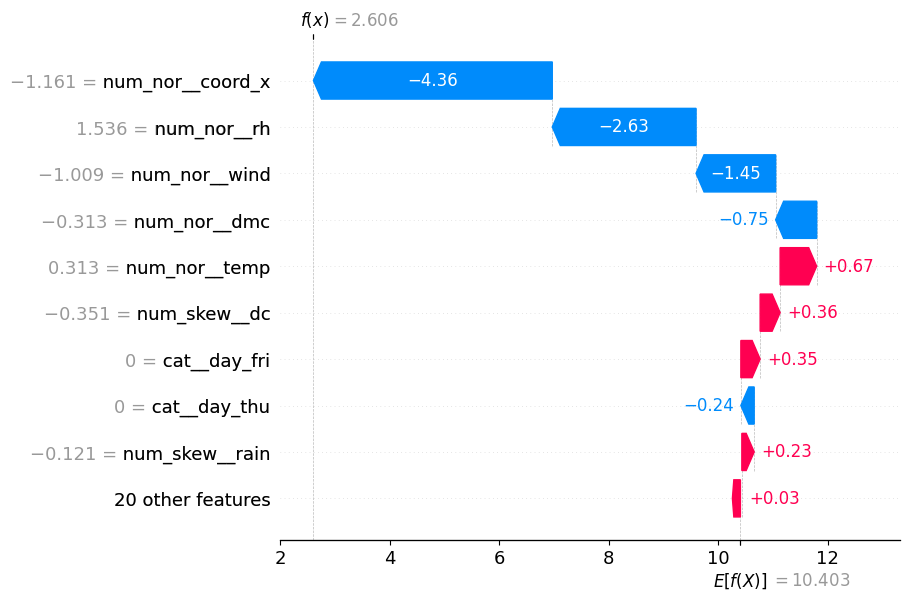

y_true: 2.606433170584342


In [ ]:
import shap
# transform X_test with the fitted preproc in pipe b
data_transform = best_model_b.named_steps['preprocessing'].transform(X_test)

# SHAP explainer for Ridge
explainer = shap.explainers.Linear(
    best_model_b.named_steps['regressor'],
    data_transform,
    feature_names = best_model_b.named_steps['preprocessing'].get_feature_names_out()
)

shap_values = explainer(data_transform)
# pick a obs from test set
i = 9  

# Waterfall plot (for local explanation)
shap.plots.waterfall(shap_values[i])

y_pred_i = best_model_b.predict(X_test.iloc[[i]])[0]
print("y_true:", y_pred_i)

In [42]:
import numpy as np
# transform X_train
X_train_tr = best_model_b.named_steps["preprocessing"].transform(X_train)

explainer = shap.explainers.Linear(
    best_model_b.named_steps["regressor"],
    X_train_tr,
    feature_names=best_model_b.named_steps["preprocessing"].get_feature_names_out()
)

shap_train = explainer(X_train_tr)

# take mean absolute SHAP
mean_abs = np.abs(shap_train.values).mean(axis=0)
imp = pd.Series(mean_abs, index=shap_train.feature_names).sort_values(ascending=False)
# most important
print(f'most imporatant feature is {imp.head(5)}')   
# least important
print(f'least imporatant feature is {imp.tail(5)}')   


most imporatant feature is num_nor__dmc        3.398158
num_nor__coord_x    3.210938
num_nor__temp       1.659603
num_nor__rh         1.276333
num_nor__wind       1.100551
dtype: float64
least imporatant feature is cat__month_apr    0.012108
cat__month_oct    0.003075
cat__month_jan    0.001002
cat__month_may    0.000816
cat__month_nov    0.000165
dtype: float64


*(Answer here.)*

- For our best model Ridge with pipeline B, we have observation 9, the model predicted 2.61 while the true value was 0.75.
- SHAP plot explains how the model moved from its baseline prediction of 10.403 down to this specific prediction of 2.61

- Most important features that impacted this specific prediction:
    - coord_x (num_nor__coord_x): reducing the prediction by 4.36
    - rh (relative humidity, num_nor__rh): push prediction down by 2.63
    - wind (num_nor__wind): reduced prediction by 1.45




- Across the full training set, importance is measured using mean absolute SHAP values. In the Ridge model, the most important features are coordinates and dmc, temp, rh, and wind. The least important features are one-hot encoded day/month categories.

- If i were to remove features, I would remove the lowest-importance features, because they contribute negligible marginal predictive value while increasing model complexity. In particular, the lowest-impact one-hot encoded categories are good candidates for removal.

- To validate removals, I would run after removing the least important features, refit the same model pipeline, and compare CV MAE to the original model. If CV MAE stays the same or improves, I would keep the reduced feature set. Then, I would confirm on the held-out test set to ensure the simplification does not degrade MAE.


## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.